# Setup dos dados iniciais
### Instalação de bibliotecas e imports

In [1]:
!pip install -U -q PyDrive

In [2]:
import pandas as pd
import plotly.express as px
from sklearn.preprocessing import LabelBinarizer
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
import warnings
warnings.filterwarnings('ignore')
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_classif, mutual_info_classif

### Autenticação para acesso aos dados

In [3]:
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

### Download dos dados para esta máquina virtual

In [4]:
downloaded = drive.CreateFile({'id': '1BK5Rjc5yYNojUvIyx4VjIKd3mHWzFl8J'})
downloaded.GetContentFile('data.csv')

### Carregando os dados baixados no dataframe

In [5]:
# Dados lidos do arquvio csv
df = pd.read_csv('data.csv')

# Definição de dataframe que será utilizado na seção de mapeamento de jornada do usuário
new_df = df.copy()

# Filtrando a base de dados com um único mês
last_month = df.anomes == 202204
df = df[last_month]

# Mostrando primeiros registros do Dataframe
df.head()

,anomes,num_cpf_hash,vlr_credito,vlr_saldo,num_atend_atrs,vlr_score,num_produtos,num_atend,qtd_oper,qtd_reclm,qtd_restr,vlr_renda,cod_rating,ind_atrito,ind_engaj,ind_novo_cli
0,202204,cb12b6e129afbe2cc514ca053b8914992b4c8f73087cb9...,6667.88,1360.96,NaN,446.0,1.0,NaN,8.0,NaN,7.0,"1650,00",A,NaN,NaN,NaN
4,202204,19039d3944f2f19e53debd4ca61514d185b53e3f3d52dc...,NaN,NaN,NaN,148.0,NaN,NaN,NaN,NaN,1.0,"750,00",NaN,NaN,NaN,NaN
18,202204,4e88066de269003d043093fa2253327f9823625de498c3...,1599.31,64.02,NaN,134.0,1.0,NaN,3.0,NaN,2.0,"1100,00",H,NaN,NaN,NaN
30,202204,d8ed0b200dfdf8ea0a804fbcc00d05415224a5938bcff4...,10921.59,1264.50,NaN,334.0,2.0,NaN,12.0,NaN,5.0,"2050,00",D,NaN,NaN,NaN
35,202204,49a351b1547a451f103c0c0f0a047f062d6f00538b4a3a...,305.47,1400.00,NaN,403.0,1.0,NaN,6.0,NaN,2.0,"4400,00",A,NaN,NaN,NaN


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 851414 entries, 0 to 11886317
Data columns (total 16 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   anomes          851414 non-null  int64  
 1   num_cpf_hash    851414 non-null  object 
 2   vlr_credito     464590 non-null  float64
 3   vlr_saldo       435627 non-null  float64
 4   num_atend_atrs  521 non-null     float64
 5   vlr_score       851116 non-null  float64
 6   num_produtos    435627 non-null  float64
 7   num_atend       1550 non-null    float64
 8   qtd_oper        464590 non-null  float64
 9   qtd_reclm       57 non-null      float64
 10  qtd_restr       604557 non-null  float64
 11  vlr_renda       851414 non-null  object 
 12  cod_rating      435627 non-null  object 
 13  ind_atrito      216 non-null     float64
 14  ind_engaj       147745 non-null  float64
 15  ind_novo_cli    170899 non-null  float64
dtypes: float64(12), int64(1), object(3)
memory usage: 110.

In [7]:
df.describe(include="object")

,num_cpf_hash,vlr_renda,cod_rating
count,851414,851414,435627
unique,851414,2085,10
top,cb12b6e129afbe2cc514ca053b8914992b4c8f73087cb9...,"4300,00",A
freq,1,50282,330229


# Manipulação dos dados das colunas da base de dados geral
##### Preenchemos os valores vazios das colunas e tratamos dados que estavam com a tipagem errada.

Transformando string para float



In [8]:
df["vlr_renda"] = df["vlr_renda"].str.replace(',','.')
df["vlr_renda"] = df["vlr_renda"].astype(float)

Nas seguinte células, transformamos os valores NaN das colunas em 0

In [9]:
df['ind_atrito'] = df['ind_atrito'].fillna(0)

In [10]:
df['ind_engaj'] = df['ind_engaj'].fillna(0)

In [11]:
df['ind_novo_cli'] = df['ind_novo_cli'].fillna(0)

In [12]:
df['num_atend'] = df['num_atend'].fillna(0)

In [13]:
df['num_atend_atrs'] = df['num_atend_atrs'].fillna(0)

In [14]:
df['qtd_reclm'] = df['qtd_reclm'].fillna(0) 




# Divisão da tabela entre clientes e não clientes





In [15]:
client = df[df.cod_rating.notna()]
not_client = df[df.cod_rating.isna()]

#Visualização gráfica de hipóteses


##Hipótese 1
Clientes com o score mais alto possuem um valor de saldo no banco pan maior (Hipótese não comprovada).

In [16]:
fig = px.scatter(client.sample(10000), x = "vlr_score", y = "vlr_saldo")
fig.show()

##Hipótese 2
O banco pan possui mais clientes com classificação A do que H (Comprovada).


In [17]:
client.cod_rating.describe()

count     435627
unique        10
top            A
freq      330229
Name: cod_rating, dtype: object

##Hipótese 3
Como o banco atende a clientes de baixa renda, acreditamos que eles contratem vários produtos com baixos valores (Comprovada). 


In [18]:
fig = px.scatter(client.sample(10000), x = "qtd_oper", y = "vlr_saldo")
fig.show()

#Remoção de colunas

Após a análise preliminar com os dados, vamos observar quais features seriam interessantes segundo o método KBest da biblioteca SKLearn, que verifica quais colunas são mais interessantes para o resultado que buscamos.

## Remoção das colunas que não iremos utilizar da tabela de clientes

In [19]:
client = client.drop('cod_rating', axis=1)

In [20]:
client = client.drop('ind_novo_cli', axis=1)

In [21]:
client = client.drop('num_cpf_hash', axis=1)

In [22]:
client = client.drop('anomes', axis=1)

## Remoção das colunas que não iremos utilizar da tabela de não clientes

In [23]:
not_client = not_client.drop('vlr_saldo', axis=1)

In [24]:
not_client = not_client.drop('cod_rating', axis=1)

In [25]:
not_client = not_client.drop('ind_atrito', axis=1)

In [26]:
not_client = not_client.drop('ind_engaj', axis=1)

In [27]:
not_client = not_client.drop('num_cpf_hash', axis=1)

In [28]:
not_client = not_client.drop('num_produtos', axis=1)

In [29]:
not_client = not_client.drop('anomes', axis=1)

In [30]:
not_client = not_client.drop('qtd_oper', axis=1)

# Remoção das linhas com valores vazios (NaN)

In [31]:
client = client.dropna()
not_client = not_client.dropna()

#Visualização dos dados
###Tabela completa:

In [32]:
df.describe()

,anomes,vlr_credito,vlr_saldo,num_atend_atrs,vlr_score,num_produtos,num_atend,qtd_oper,qtd_reclm,qtd_restr,vlr_renda,ind_atrito,ind_engaj,ind_novo_cli
count,851414.0,4.645900e+05,4.356270e+05,851414.000000,851116.000000,435627.000000,851414.000000,464590.000000,851414.000000,604557.000000,851414.000000,851414.000000,851414.000000,851414.000000
mean,202204.0,3.441006e+04,5.749114e+03,0.000682,440.869032,2.615591,0.002493,12.625160,0.000067,3.044356,3451.888682,0.000254,0.173529,0.200724
std,0.0,7.105371e+04,1.031318e+04,0.029612,205.964872,2.667028,0.064932,11.051452,0.008182,3.792966,6206.799900,0.015926,0.378704,0.400542
min,202204.0,0.000000e+00,1.000000e-02,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000
25%,202204.0,3.545455e+03,9.993000e+02,0.000000,304.000000,1.000000,0.000000,5.000000,0.000000,1.000000,1250.000000,0.000000,0.000000,0.000000
50%,202204.0,1.545219e+04,2.424330e+03,0.000000,402.000000,2.000000,0.000000,10.000000,0.000000,2.000000,1750.000000,0.000000,0.000000,0.000000
75%,202204.0,3.653325e+04,6.712735e+03,0.000000,575.000000,3.000000,0.000000,17.000000,0.000000,4.000000,4250.000000,0.000000,0.000000,0.000000
max,202204.0,1.034811e+07,1.666399e+06,6.000000,1000.000000,96.000000,9.000000,265.000000,1.000000,217.000000,550750.000000,1.000000,1.000000,1.000000


###Tabela clientes:

In [33]:
client.describe()

,vlr_credito,vlr_saldo,num_atend_atrs,vlr_score,num_produtos,num_atend,qtd_oper,qtd_reclm,qtd_restr,vlr_renda,ind_atrito,ind_engaj
count,1.858800e+05,185880.000000,185880.000000,185880.000000,185880.000000,185880.000000,185880.000000,185880.000000,185880.00000,185880.000000,185880.000000,185880.000000
mean,4.112444e+04,5565.679638,0.000936,375.723268,2.506472,0.003578,14.076001,0.000151,3.30857,3855.009415,0.000522,0.340515
std,6.715217e+04,9556.055169,0.032459,143.455257,2.237989,0.074894,10.516395,0.012272,3.74673,6151.065231,0.022838,0.473884
min,0.000000e+00,0.010000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1.00000,250.000000,0.000000,0.000000
25%,7.896820e+03,880.052500,0.000000,285.000000,1.000000,0.000000,7.000000,0.000000,1.00000,1350.000000,0.000000,0.000000
50%,2.074161e+04,2185.470000,0.000000,384.000000,2.000000,0.000000,12.000000,0.000000,2.00000,2200.000000,0.000000,0.000000
75%,4.597636e+04,6191.815000,0.000000,462.000000,3.000000,0.000000,18.000000,0.000000,4.00000,4300.000000,0.000000,1.000000
max,3.699561e+06,741055.970000,2.000000,973.000000,88.000000,5.000000,265.000000,1.000000,110.00000,360200.000000,1.000000,1.000000


###Tabela não clientes:

In [34]:
not_client.describe()

,vlr_credito,num_atend_atrs,vlr_score,num_atend,qtd_reclm,qtd_restr,vlr_renda,ind_novo_cli
count,5.922000e+04,59220.000000,59220.000000,59220.000000,59220.000000,59220.000000,59220.000000,59220.000000
mean,1.116576e+04,0.000152,287.116211,0.000540,0.000017,3.291692,2381.376224,0.276292
std,4.897024e+04,0.013628,133.671909,0.025326,0.004109,3.780653,3443.226629,0.447167
min,0.000000e+00,0.000000,0.000000,0.000000,0.000000,1.000000,350.000000,0.000000
25%,0.000000e+00,0.000000,176.000000,0.000000,0.000000,1.000000,1150.000000,0.000000
50%,9.382750e+02,0.000000,274.000000,0.000000,0.000000,2.000000,1400.000000,0.000000
75%,5.099010e+03,0.000000,376.000000,0.000000,0.000000,4.000000,3500.000000,1.000000
max,7.638867e+06,2.000000,961.000000,2.000000,1.000000,217.000000,193600.000000,1.000000


# Feature Engineering com o uso do SKLearn


##Atritado

In [35]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_classif, mutual_info_classif

In [36]:
# Identificar as variáveis entre colunas de análise e coluna de resposta do teste
x = client.drop(['ind_atrito', 'ind_engaj'], axis=1)
y = client['ind_atrito']

In [37]:
# Chamar o método que verifica os melhores parâmetros f_classif que utiliza da progressão linear para ajustar os dados
f_classif = SelectKBest(score_func=f_classif, k=4)

In [38]:
fit = f_classif.fit(x, y)

In [39]:
features = fit.transform(x)

In [40]:
# Fazer aparecer o nome das colunas que o método julgou interessante
cols = fit.get_support(indices=True)
x.iloc[:, cols]

,vlr_saldo,num_atend_atrs,qtd_reclm,vlr_renda
0,1360.96,0.0,0.0,1650.0
18,64.02,0.0,0.0,1100.0
30,1264.50,0.0,0.0,2050.0
35,1400.00,0.0,0.0,4400.0
85,700.00,0.0,0.0,4250.0
...,...,...,...,...
11886194,4498.00,0.0,0.0,1300.0
11886221,4135.03,0.0,0.0,3150.0
11886229,21242.84,0.0,0.0,1000.0
11886303,1000.00,0.0,0.0,3550.0


Com este novo teste, podemos perceber que estávamos na direção correta em nossa análise, mas que deixamos passar a coluna do num_atend, que julgamos não ser relevante a resposta final, mas que o algoritmo considera importante. 

##Engajado

In [41]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_classif, mutual_info_classif

In [42]:
#Definindo as variáveis que serão usadas para a feature engineering
x = client.drop(['ind_atrito', 'ind_engaj'], axis = 1)
y = client['ind_engaj']

In [43]:
## Chamar o método que verifica os melhores parâmetros f_classif que utiliza da progressão linear para ajustar os dados e utilizando as top 4 features
f_classif = SelectKBest (score_func=f_classif, k=4)

In [44]:
fit = f_classif.fit(x, y)

In [45]:
features = fit.transform(x)

In [46]:
cols = fit.get_support(indices=True)
x.iloc[:, cols]

,vlr_credito,vlr_saldo,num_produtos,qtd_oper
0,6667.88,1360.96,1.0,8.0
18,1599.31,64.02,1.0,3.0
30,10921.59,1264.50,2.0,12.0
35,305.47,1400.00,1.0,6.0
85,51878.67,700.00,1.0,31.0
...,...,...,...,...
11886194,10384.70,4498.00,1.0,11.0
11886221,100116.42,4135.03,7.0,31.0
11886229,25947.83,21242.84,5.0,7.0
11886303,2170.00,1000.00,1.0,9.0


##Novo cliente

In [47]:
#Importar a biblioteca
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_classif, mutual_info_classif

In [48]:
# Identificar as variáveis entre colunas de análise e coluna de resposta do teste
x = not_client.drop(['ind_novo_cli'], axis=1)
y = not_client['ind_novo_cli']

In [49]:
# Chamar o método que verifica os melhores parâmetros f_classif que utiliza da progressão linear para ajustar os dados
f_classif = SelectKBest(score_func = f_classif, k=4)

In [50]:
fit = f_classif.fit(x, y)

In [51]:
features = fit.transform(x)

In [52]:
# Fazer aparecer o nome das colunas que o método julgou interessante
cols = fit.get_support(indices=True)
x.iloc[:, cols]

,vlr_credito,vlr_score,qtd_restr,vlr_renda
152,760.81,502.0,1.0,900.0
209,0.00,170.0,2.0,4250.0
891,1683.36,183.0,2.0,600.0
1033,4315.88,581.0,1.0,3500.0
1167,0.00,153.0,1.0,1300.0
...,...,...,...,...
11883342,537.36,397.0,2.0,3650.0
11885919,61658.13,146.0,6.0,850.0
11886057,0.00,272.0,1.0,750.0
11886185,4815.51,189.0,6.0,1500.0


# Normalização e padronização das colunas

(array([1.85717e+05, 0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00,
        0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00,
        0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00,
        0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00,
        0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00,
        1.52000e+02, 0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00,
        0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00,
        0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00,
        0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00,
        0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00, 1.10000e+01]),
 array([0.  , 0.04, 0.08, 0.12, 0.16, 0.2 , 0.24, 0.28, 0.32, 0.36, 0.4 ,
        0.44, 0.48, 0.52, 0.56, 0.6 , 0.64, 0.68, 0.72, 0.76, 0.8 , 0.84,
        0.88, 0.92, 0.96, 1.  , 1.04, 1.08, 1.12, 1.16, 1.2 , 1.24, 1.28,
        1.32, 1.36, 1.4 , 1.44, 1.48, 1.52, 1.

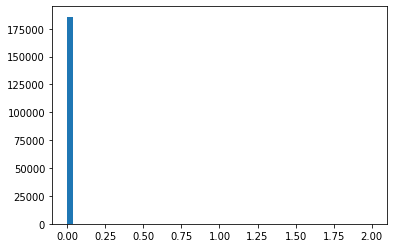

In [53]:
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.preprocessing import MinMaxScaler
plt.hist(client['num_atend_atrs'], bins=50)

In [54]:
client.describe()

,vlr_credito,vlr_saldo,num_atend_atrs,vlr_score,num_produtos,num_atend,qtd_oper,qtd_reclm,qtd_restr,vlr_renda,ind_atrito,ind_engaj
count,1.858800e+05,185880.000000,185880.000000,185880.000000,185880.000000,185880.000000,185880.000000,185880.000000,185880.00000,185880.000000,185880.000000,185880.000000
mean,4.112444e+04,5565.679638,0.000936,375.723268,2.506472,0.003578,14.076001,0.000151,3.30857,3855.009415,0.000522,0.340515
std,6.715217e+04,9556.055169,0.032459,143.455257,2.237989,0.074894,10.516395,0.012272,3.74673,6151.065231,0.022838,0.473884
min,0.000000e+00,0.010000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1.00000,250.000000,0.000000,0.000000
25%,7.896820e+03,880.052500,0.000000,285.000000,1.000000,0.000000,7.000000,0.000000,1.00000,1350.000000,0.000000,0.000000
50%,2.074161e+04,2185.470000,0.000000,384.000000,2.000000,0.000000,12.000000,0.000000,2.00000,2200.000000,0.000000,0.000000
75%,4.597636e+04,6191.815000,0.000000,462.000000,3.000000,0.000000,18.000000,0.000000,4.00000,4300.000000,0.000000,1.000000
max,3.699561e+06,741055.970000,2.000000,973.000000,88.000000,5.000000,265.000000,1.000000,110.00000,360200.000000,1.000000,1.000000


In [55]:
not_client.describe()

,vlr_credito,num_atend_atrs,vlr_score,num_atend,qtd_reclm,qtd_restr,vlr_renda,ind_novo_cli
count,5.922000e+04,59220.000000,59220.000000,59220.000000,59220.000000,59220.000000,59220.000000,59220.000000
mean,1.116576e+04,0.000152,287.116211,0.000540,0.000017,3.291692,2381.376224,0.276292
std,4.897024e+04,0.013628,133.671909,0.025326,0.004109,3.780653,3443.226629,0.447167
min,0.000000e+00,0.000000,0.000000,0.000000,0.000000,1.000000,350.000000,0.000000
25%,0.000000e+00,0.000000,176.000000,0.000000,0.000000,1.000000,1150.000000,0.000000
50%,9.382750e+02,0.000000,274.000000,0.000000,0.000000,2.000000,1400.000000,0.000000
75%,5.099010e+03,0.000000,376.000000,0.000000,0.000000,4.000000,3500.000000,1.000000
max,7.638867e+06,2.000000,961.000000,2.000000,1.000000,217.000000,193600.000000,1.000000


In [56]:
def normalizeColumn(dataFrame, columnName): 
  return (dataFrame[columnName] - dataFrame[columnName].min()) / (dataFrame[columnName].max() - dataFrame[columnName].min()) 

In [57]:
client.columns

Index(['vlr_credito', 'vlr_saldo', 'num_atend_atrs', 'vlr_score',
       'num_produtos', 'num_atend', 'qtd_oper', 'qtd_reclm', 'qtd_restr',
       'vlr_renda', 'ind_atrito', 'ind_engaj'],
      dtype='object')

## Cliente


In [58]:
clientNormalizeColumns = ['vlr_credito', 'vlr_saldo', 'num_atend_atrs', 
       'num_produtos', 'num_atend', 'qtd_oper', 'qtd_reclm', 'qtd_restr',
       'vlr_renda']

In [59]:
for column in clientNormalizeColumns:
  client[column] = normalizeColumn(client, column)

In [60]:
from sklearn.preprocessing import StandardScaler
client[['vlr_score']] = StandardScaler().fit_transform(client[['vlr_score']])

In [61]:
client.head(5)

,vlr_credito,vlr_saldo,num_atend_atrs,vlr_score,num_produtos,num_atend,qtd_oper,qtd_reclm,qtd_restr,vlr_renda,ind_atrito,ind_engaj
0,0.001802,0.001837,0.0,0.489887,0.000000,0.0,0.030189,0.0,0.055046,0.003889,0.0,0.0
18,0.000432,0.000086,0.0,-1.685013,0.000000,0.0,0.011321,0.0,0.009174,0.002361,0.0,0.0
30,0.002952,0.001706,0.0,-0.290846,0.011494,0.0,0.045283,0.0,0.036697,0.005001,0.0,0.0
35,0.000083,0.001889,0.0,0.190142,0.000000,0.0,0.022642,0.0,0.009174,0.011529,0.0,0.0
85,0.014023,0.000945,0.0,-0.402379,0.000000,0.0,0.116981,0.0,0.027523,0.011113,0.0,0.0


## Não cliente


In [62]:
not_client.columns

Index(['vlr_credito', 'num_atend_atrs', 'vlr_score', 'num_atend', 'qtd_reclm',
       'qtd_restr', 'vlr_renda', 'ind_novo_cli'],
      dtype='object')

In [63]:
notClientNormalizeColumns = ['vlr_credito', 'num_atend_atrs', 'num_atend', 'qtd_reclm',
       'qtd_restr', 'vlr_renda']

In [64]:
for column in notClientNormalizeColumns:
  not_client[column] = normalizeColumn(not_client, column)

In [65]:
from sklearn.preprocessing import StandardScaler
not_client[['vlr_score']] = StandardScaler().fit_transform(not_client[['vlr_score']])

In [66]:
not_client.head()

,vlr_credito,num_atend_atrs,vlr_score,num_atend,qtd_reclm,qtd_restr,vlr_renda,ind_novo_cli
152,0.000100,0.0,1.607560,0.0,0.0,0.00000,0.002846,1.0
209,0.000000,0.0,-0.876154,0.0,0.0,0.00463,0.020181,0.0
891,0.000220,0.0,-0.778900,0.0,0.0,0.00463,0.001294,0.0
1033,0.000565,0.0,2.198564,0.0,0.0,0.00000,0.016300,1.0
1167,0.000000,0.0,-1.003332,0.0,0.0,0.00000,0.004916,0.0


# Salvando a base de dados manipulada em novos arquivos csv

In [67]:
# Importamos a biblioteca drive do google.colab
from google.colab import drive
         
# Estabelecemos os caminhos para o download poder ser executado
drive.mount(r'/content/drive')
path = r'/content/drive/My Drive/Pandevs/client.csv'

# Baixando nosso df no formato de csv em nosso drive
with open(path, 'w', encoding = 'utf-8-sig') as f:
  client.to_csv(f)

Mounted at /content/drive


FileNotFoundError: ignored

In [ ]:
# Estabelecemos os caminhos para o download poder ser executado
drive.mount(r'/content/drive')
path = r'/content/drive/My Drive/Pandevs/not_client.csv'

# Baixando nosso df no formato de csv em nosso drive
with open(path, 'w', encoding = 'utf-8-sig') as f:
  not_client.to_csv(f)

# Seleção de Features

Iremos selecionar as features que são interessantes para identificar se um cliente é caracterizado como um novo cliente.

In [ ]:
# Nesta variável estamos armazenando os clientes que têm índice 1 na coluna ind_novo_cli
new_client_ind_1 = not_client[not_client.ind_novo_cli == 1] 

# Nesta variável estamos armazenando os clientes que têm índice 0 na coluna ind_novo_cli
new_client_ind_0 = not_client[not_client.ind_novo_cli != 1] 

## Novo cliente

Relação entre o desejo do banco em ter um cliente (0 = quer como cliente; 1 = não quer como cliente) e o Score do mercado.

In [ ]:
fig = px.bar(y = [new_client_ind_1['vlr_score'].mean(), new_client_ind_0['vlr_score'].mean()], x = ['Clientes desejados', 'Clientes não desejados'])#foi passado uma lista com 2 dados dentro de uma máscara com a média dos Scores de clientes que o banco deseja, ou não para compararmos.
fig.show()

Relação entre o desejo do banco em ter um cliente (0 = quer como cliente; 1 = não quer como cliente) e o crédito que ele tem no mercado.

In [ ]:
fig = px.bar(y = [new_client_ind_1['vlr_credito'].mean(), new_client_ind_0['vlr_credito'].mean()], x = ['Crédito do cliente desejado','Crédito do cliente não desejado'])
fig.show()

Relação entre o desejo do banco em ter um cliente (0 = quer como cliente; 1 = não quer como cliente) e a quantidade de restrições que ele tem no mercado.

In [ ]:
fig = px.bar(y = [new_client_ind_1['qtd_restr'].mean(), new_client_ind_0['qtd_restr'].mean()], x = ['Restritivos do cliente desejado', 'Restritivos do cliente não desejado'])
fig.show()

##Cliente engajado

Iremos selecionar as features que são interessantes para identificar se um cliente é caracterizado como um cliente engajado.

In [ ]:
client_engaged = client[client.ind_engaj == 1]#Nesta variável estamos armazenando os clientes que têm índice 1 na coluna ind_novo_cli
client_not_engaged = client[client.ind_engaj != 1]#Nesta variável estamos armazenando os clientes que têm índice 0 na coluna ind_novo_cli

Relação entre o banco acreditar que um cliente é engajado (0 = é engajado; 1 = não é engajado) e a quantidade de produtos que ele tem.

In [ ]:
fig = px.bar(y = [client_engaged['num_produtos'].mean(), client_not_engaged['num_produtos'].mean()], x = ['Produtos de clientes engajados', ' Produtos de clientes não engajados'])
fig.show()

Relação entre o banco acreditar que um cliente é engajado (0 = é engajado; 1 = não é engajado) e a quantidade de operações que ele tem.

In [ ]:
fig = px.bar(y = [client_engaged['qtd_oper'].mean(), client_not_engaged['qtd_oper'].mean()], x = ['Operações de clientes engajados', ' Operações de clientes não engajados'])
fig.show()

Relação entre o banco acreditar que um cliente é engajado (0 = é engajado; 1 = não é engajado) e a quantidade de crédito que ele tem.

In [ ]:
fig = px.bar(y = [client_engaged['vlr_credito'].mean(), client_not_engaged['vlr_credito'].mean()], x = ['Crédito do cliente engajado', 'Crédito do cliente não engajado'])
fig.show()

Relação entre o banco acreditar que um cliente é engajado (0 = é engajado; 1 = não é engajado) e a quantidade de saldo que ele tem.

In [ ]:
fig = px.bar(y = [client_engaged['vlr_saldo'].mean(), client_not_engaged['vlr_saldo'].mean()], x = ['Saldo do cliente engajado', 'Saldo cliente não engajado'])
fig.show()

##Cliente atritado

In [ ]:
client_fretted = df[df.ind_atrito == 1]#Nesta variável estamos armazenando os clientes que têm índice 1 na coluna ind_atrito
client_not_fretted = df[df.ind_atrito != 1]#Nesta variável estamos armazenando os clientes que têm índice 0 na coluna ind_atrito

Relação entre o banco acreditar que um cliente é atritado (0 = é atritado; 1 = não é atritado) e a quantidade de operações.

In [ ]:
fig = px.bar(y = [client_fretted['qtd_oper'].mean(), client_not_fretted['qtd_oper'].mean()], x = ['Operações de clientes atritados', ' Operações clientes não atritados'])
fig.show()

Relação entre o banco acreditar que um cliente é atritado (0 = é atritado; 1 = não é atritado) e a quantidade de produtos.

In [ ]:
fig = px.bar(y = [client_fretted['num_produtos'].mean(), client_not_fretted['num_produtos'].mean()], x = ['Produtos de clientes atritados', 'Produtos de clientes não atritados'])
fig.show()

Relação entre o banco acreditar que um cliente é atritado (0 = é atritado; 1 = não é atritado) e o valor do Score.

In [ ]:
fig = px.bar(y = [client_fretted['vlr_score'].mean(), client_not_fretted['vlr_score'].mean()], x = ['Score dos clientes atritados', 'Score dos clienets não atritados'])
fig.show()

Relação entre o banco acreditar que um cliente é atritado (0 = é atritado; 1 = não é atritado) e o valor de crédito.

In [ ]:
fig = px.bar(y = [client_fretted['vlr_credito'].mean(), client_not_fretted['vlr_credito'].mean()], x = ['Crédito dos clientes atritados', 'Crédito dos clientes não atritados'])
fig.show()

Relação entre o banco acreditar que um cliente é atritado (0 = é atritado; 1 = não é atritado) e o valor do saldo.

In [ ]:
fig = px.bar(y = [client_fretted['vlr_saldo'].mean(), client_not_fretted['vlr_saldo'].mean()], x = ['Saldo dos clientes atritados', 'Saldo dos clientes não atritatados'])
fig.show()

#  Visualização de Jornada do usuário
1. Atritado
    Foram coletados 3 CPFs para comparar as ações de acordo com as safras

In [ ]:
# Coletar o ID do cpf a partir da última safra
df[(df.anomes == 202204) & (df.ind_atrito == 1)].head() 

In [ ]:
# Coletar o número completo do cpf para analisar cada safra
new_df.loc[9269696,'num_cpf_hash']

In [ ]:
# Visualização de cada mês de um cpf
new_df[(new_df.num_cpf_hash == 'fe7728cf4b196eedfae889dff044eca220e42c72bb837f158c420649fd738e2d')]

In [ ]:
new_df[(new_df.num_cpf_hash == '0069c06b6016281ff4af4f6b585d89b4efa25c270de9cbf857253db1bd47f3f2')]

In [ ]:
new_df[(new_df.num_cpf_hash == '01cf69537ed0cad6e0a3ecb6f6913cf0f1572ee12f64e4757a05a706707c406d')]

Os resultados das análises, comparando os três cpfs, foram inconclusivos

2. Engajado

In [ ]:
# Coletar o ID do cpf a partir da última safra
new_df[(new_df.anomes == 202111) & (new_df.ind_engaj == 1)].head()

In [ ]:
# Coletar o número do cpf completo pelo ID
new_df.loc[7532135	,'num_cpf_hash']

In [ ]:
# Visualização de cada mês de um cpf
new_df[(new_df.num_cpf_hash == '00003671431c71ae1a84ec138b63c7a6e465f9616af5ea9ab0c2572da9c2f204')]

Os resultados apresentados foram inconclusivos, de acordo com as hipóteses testadas